<a href="https://colab.research.google.com/github/763730440/AI-ML-Salary-Insights-Predictive-Modeling-for-Data-Driven-Compensation-Decisions/blob/main/AI_ML_Salary_Insights_Predictive_Modeling_for_Data_Driven_Compensation_Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries and Data loading and preliminary viewing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load data directly from GitHub URL
url = "https://raw.githubusercontent.com/763730440/AI-ML-Salary-Insights-Predictive-Modeling-for-Data-Driven-Compensation-Decisions/main/salaries.csv"
data = pd.read_csv(url)

# View basic information of the dataset
print(data.head())
print(data.info())

   work_year experience_level employment_type           job_title  salary  \
0       2024               MI              FT  Analytics Engineer   77500   
1       2024               SE              FT        AI Developer  252000   
2       2024               SE              FT        AI Developer  168000   
3       2024               MI              FT      Data Scientist  199500   
4       2024               MI              FT      Data Scientist   86700   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             CAD          59615                 CA           100   
1             USD         252000                 US             0   
2             USD         168000                 US             0   
3             USD         199500                 US           100   
4             USD          86700                 US           100   

  company_location company_size  
0               CA            S  
1               US            M  
2               US  

Feature engineering: creating new features

In [2]:
# Job Demand Score
def job_demand_score(row):
    if row['company_size'] in ['L', 'M'] and row['remote_ratio'] >= 50:
        return 'High'
    elif row['company_size'] == 'S' and row['remote_ratio'] == 0:
        return 'Low'
    else:
        return 'Medium'

data['job_demand_score'] = data.apply(job_demand_score, axis=1)

In [3]:
# International Job Index
data['international_job_index'] = data.apply(
    lambda row: 'International' if row['employee_residence'] != row['company_location'] else 'Local', axis=1
)

# Delete the 'alary_currency' column that is not used for model training
data = data.drop(['salary_currency'], axis=1)

Data preprocessing

In [4]:
# Unihot encoding of category features
data = pd.get_dummies(data, columns=['employment_type', 'experience_level', 'job_title', 'employee_residence',
                                     'company_location', 'company_size', 'job_demand_score',
                                     'international_job_index'], drop_first=True)

# Define features and target variables
X = data.drop(['salary'], axis=1)
y = data['salary']

Dataset splitting

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model initialization and hyperparameter setting

In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Set hyperparameter search grid
param_grid = {
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
}

Model Training and Evaluation

In [9]:
# Train and evaluate the model, and perform hyperparameter tuning
for model_name, model in models.items():
    if model_name in param_grid:
        # Using grid search for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        # For linear regression, this operation is not necessary
        best_model = model
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    # Evaluation indicators
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MAE: {mae:.2f}, R²: {r2:.2f}")
    if model_name in param_grid:
        print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    else:
        print(f"Best Parameters for {model_name}: N/A")

Linear Regression - MAE: 22050.81, R²: 0.45
Best Parameters for Linear Regression: N/A
Random Forest - MAE: 6855.49, R²: 0.61
Best Parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Gradient Boosting - MAE: 8584.25, R²: 0.66
Best Parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


Visualize the best model

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Real value and predicted value

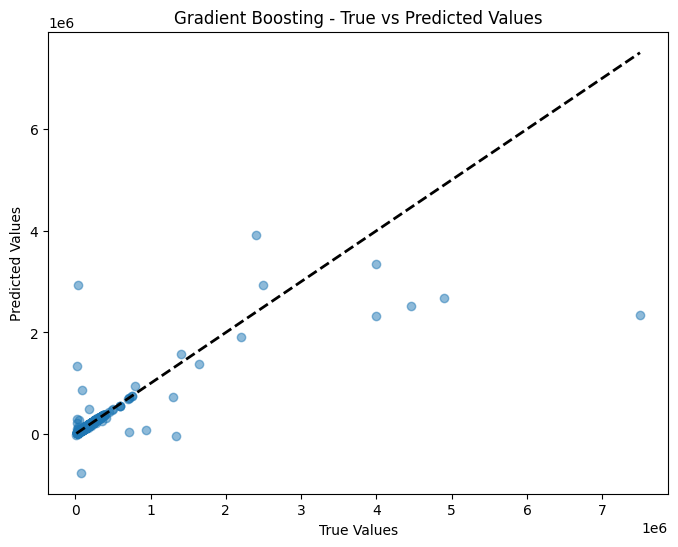

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'{model_name} - True vs Predicted Values')
plt.show()

We can see that:
Most of the points are located near the diagonal, indicating that the model predicts accurately in most cases.
However, within the higher salary range, there is a significant deviation between the predicted and actual values, indicating that the model's predictive performance on high salary data is not very good

Residual plot

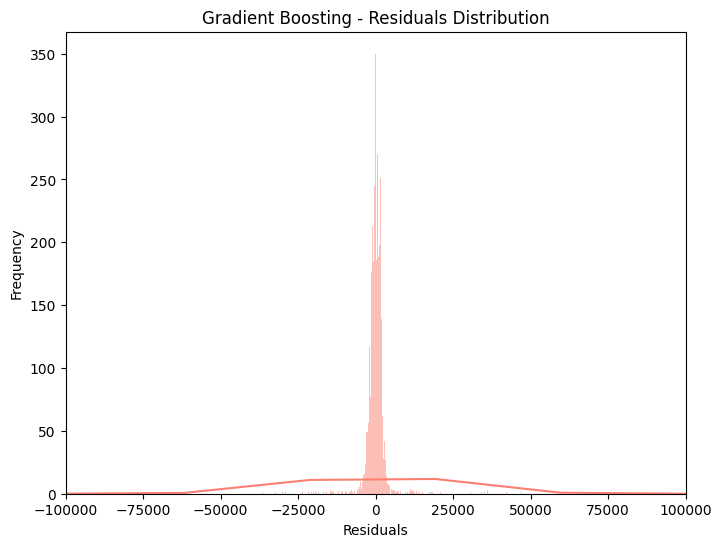

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='salmon')
plt.title(f'{model_name} - Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.xlim(-100000, 100000)
plt.show()

The residuals are concentrated around zero: most residuals are close to zero, indicating that the model has good prediction accuracy on most samples.
Peak and Sharp Distribution: The residual distribution shows a peak shape, indicating that the prediction error of most samples is very small. However, there may also be some outliers or large residuals that may be affected by extreme values or data distribution.